In [19]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [21]:
import os
for root, dirs, files in os.walk('C:\\'):
    if 'traffic.csv' in files:
        print(f"File found at: {os.path.join(root, 'traffic.csv')}")
        break

File found at: C:\Users\dell\AppData\Local\Temp\traffic.csv


In [22]:
import pandas as pd  # ✅ Add this line to import pandas

# Load the dataset
df = pd.read_csv('traffic.csv')

# Display first 5 rows
print(df.head())


   Time Protcol Flag    Family  Clusters SeddAddress ExpAddress  BTC  USD  \
0    50     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  500   
1    40     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  504   
2    30     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  508   
3    20     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  512   
4    57     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  516   

   Netflow_Bytes IPaddress Threats  Port Prediction  
0              5         A   Bonet  5061         SS  
1              8         A   Bonet  5061         SS  
2              7         A   Bonet  5061         SS  
3             15         A   Bonet  5061         SS  
4              9         A   Bonet  5061         SS  


In [23]:
from tensorflow.keras.utils import to_categorical


In [24]:
# Data Exploration
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nClass distribution:")
print(df['Threats'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB
None

First 5 rows:
   Time Protcol Flag    Family  Clusters SeddAddress ExpAddress  BTC  USD  \
0    50     TCP    A  W

In [25]:
%matplotlib inline

In [26]:
# Import all required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline





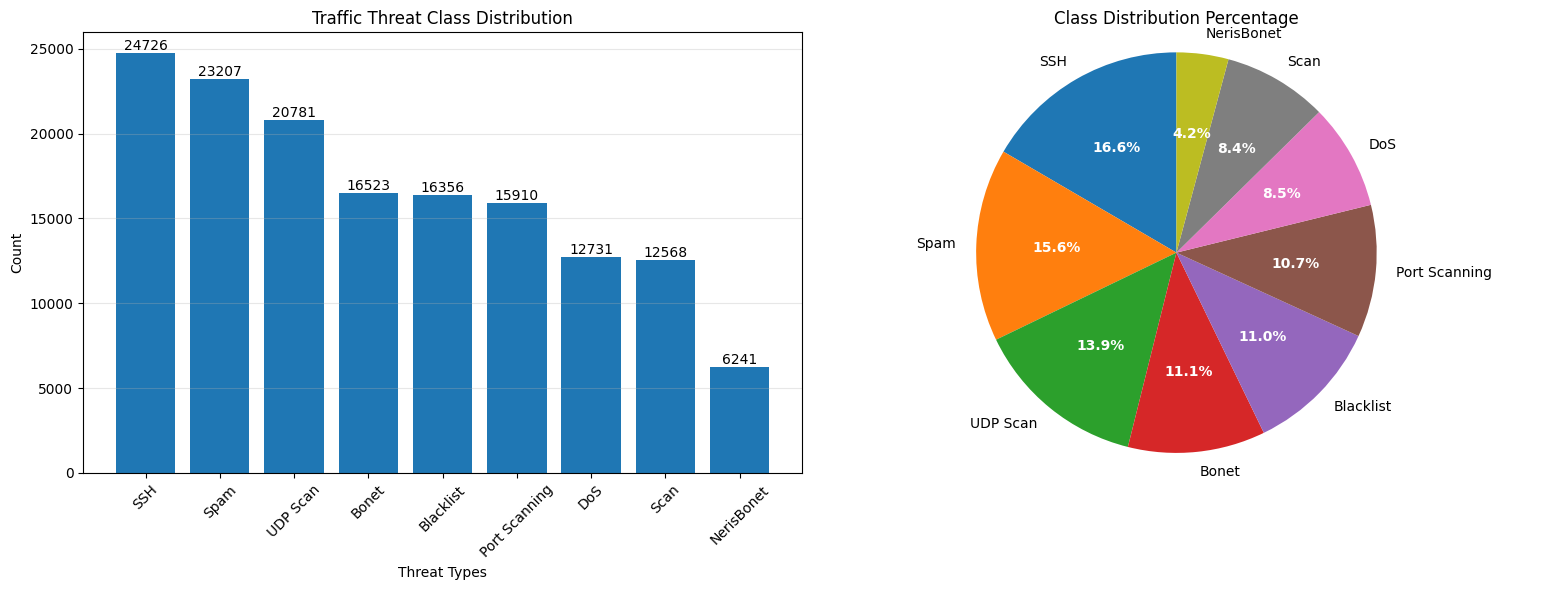

Class Distribution Statistics:
Total samples: 149043
Number of unique threat types: 9
Most common threat: SSH (24726 samples)
Least common threat: NerisBonet (6241 samples)
Imbalance ratio: 3.96:1


In [27]:
# Create subplots for better comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
threat_counts = df['Threats'].value_counts().sort_values(ascending=False)
bars = ax1.bar(threat_counts.index, threat_counts.values)
ax1.set_title('Traffic Threat Class Distribution')
ax1.set_xlabel('Threat Types')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

# Pie chart
wedges, texts, autotexts = ax2.pie(threat_counts.values, labels=threat_counts.index, 
                                   autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Distribution Percentage')
ax2.axis('equal')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Print statistical information
print("Class Distribution Statistics:")
print(f"Total samples: {len(df)}")
print(f"Number of unique threat types: {len(threat_counts)}")
print(f"Most common threat: {threat_counts.index[0]} ({threat_counts.values[0]} samples)")
print(f"Least common threat: {threat_counts.index[-1]} ({threat_counts.values[-1]} samples)")
print(f"Imbalance ratio: {threat_counts.values[0]/threat_counts.values[-1]:.2f}:1")

In [28]:
# Data Preprocessing
# Encode categorical features
categorical_cols = ['Protcol', 'Flag', 'IPaddress', 'Family', 'SeddAddress', 'ExpAddress', 'Prediction']
df_encoded = pd.get_dummies(df, columns=categorical_cols)


In [29]:
# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Threats'])
num_classes = len(np.unique(y))

In [30]:
# Prepare features
X = df_encoded.drop(['Threats'], axis=1).values

In [31]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
# Reshape for LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Calculate class weights for handling imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.0124739948201928), 1: np.float64(1.0022864444108202), 2: np.float64(1.3007581956035563), 3: np.float64(2.6533591472505953), 4: np.float64(1.0408722676164537), 5: np.float64(0.6697448168556808), 6: np.float64(1.3177066065468692), 7: np.float64(0.7136128317922016), 8: np.float64(0.7968855472013366)}


In [34]:
# Build LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)




C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Train model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

Training the model...
Epoch 1/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7550 - loss: 0.4318 - val_accuracy: 0.7599 - val_loss: 0.4223
Epoch 2/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7521 - loss: 0.4325 - val_accuracy: 0.7591 - val_loss: 0.4244
Epoch 3/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7529 - loss: 0.4318 - val_accuracy: 0.7570 - val_loss: 0.4248
Epoch 4/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7504 - loss: 0.4334 - val_accuracy: 0.7588 - val_loss: 0.4197
Epoch 5/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7560 - loss: 0.4266 - val_accuracy: 0.7582 - val_loss: 0.4216
Epoch 6/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7509 - loss: 0.4323 - val_accuracy: 0.7609 - val_loss: 0.4201
Epoch 7/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7506 - loss: 0.4321 - val_accuracy: 0.7601 - val_loss: 0.4240
Epoch 8/50
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accu

In [42]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 76.74%


In [43]:
# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

932/932 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [44]:
# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.7897
Recall: 0.7674
F1-Score: 0.7681


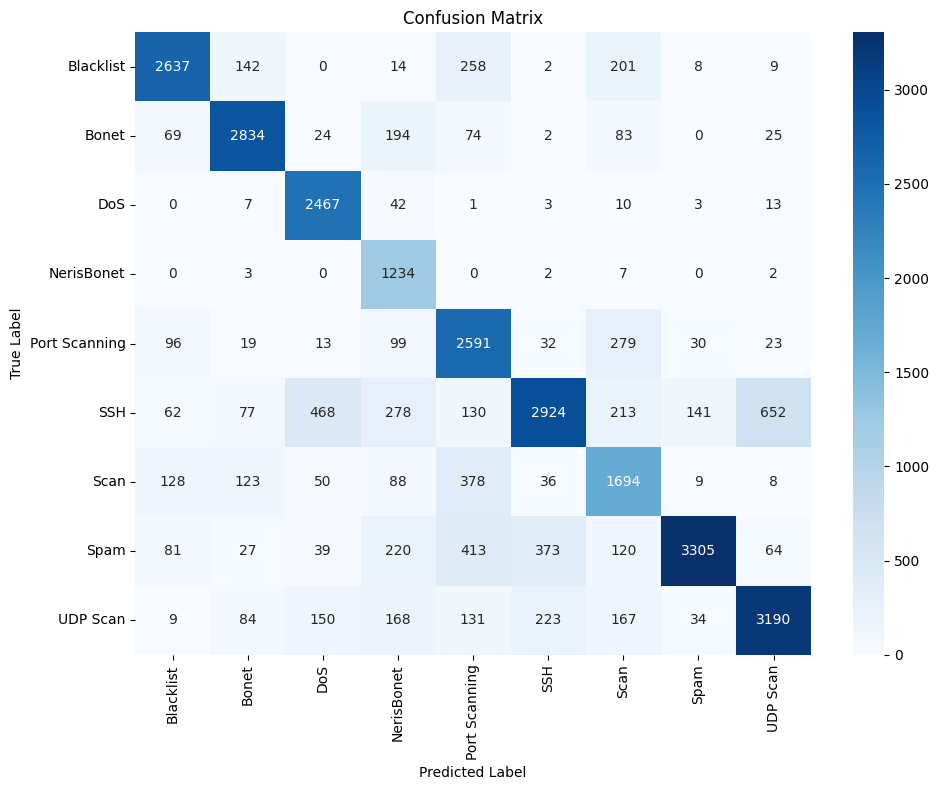

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

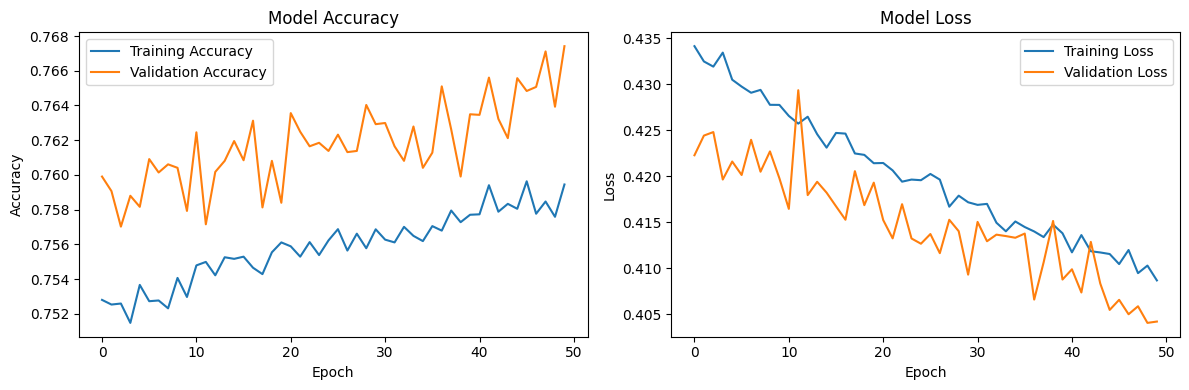

In [46]:
# Training history plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


(0.0, 1.0)

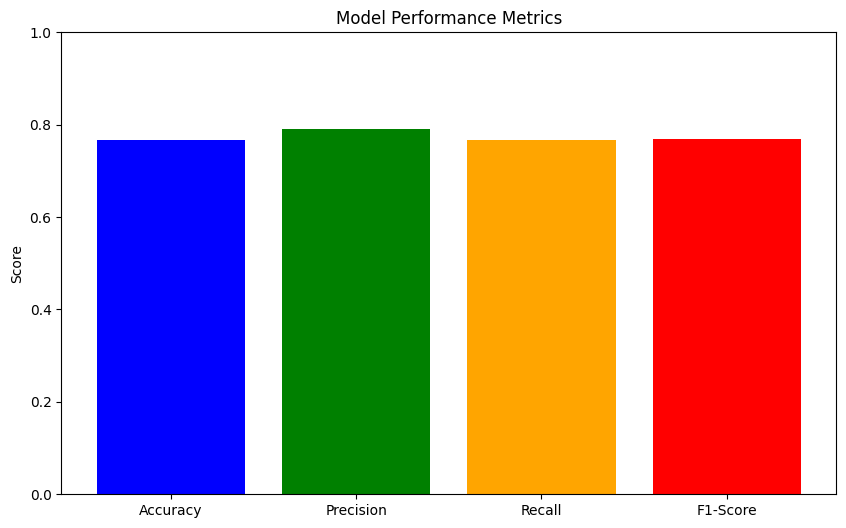

In [48]:
# Performance metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

C:\Users\dell\AppData\Local\Temp\ipykernel_13016\1227462409.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


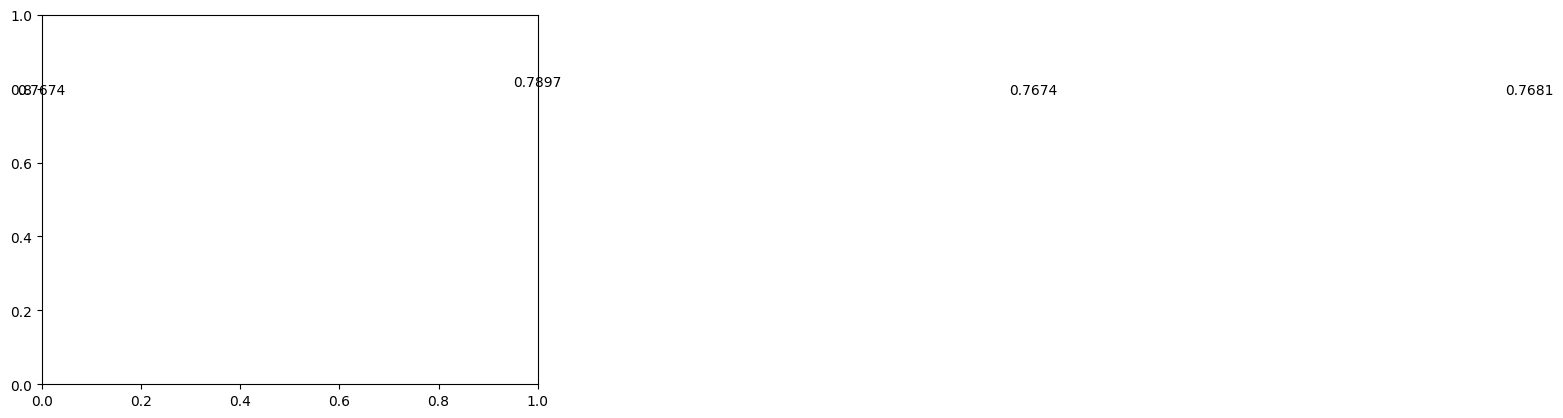

In [49]:
# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [50]:
# Class-wise performance
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

In [51]:
# Extract class-wise metrics
class_names = [cls for cls in label_encoder.classes_ if cls in class_report and isinstance(class_report[cls], dict)]
class_metrics = {
    'Precision': [class_report[cls]['precision'] for cls in class_names],
    'Recall': [class_report[cls]['recall'] for cls in class_names],
    'F1-Score': [class_report[cls]['f1-score'] for cls in class_names]
}

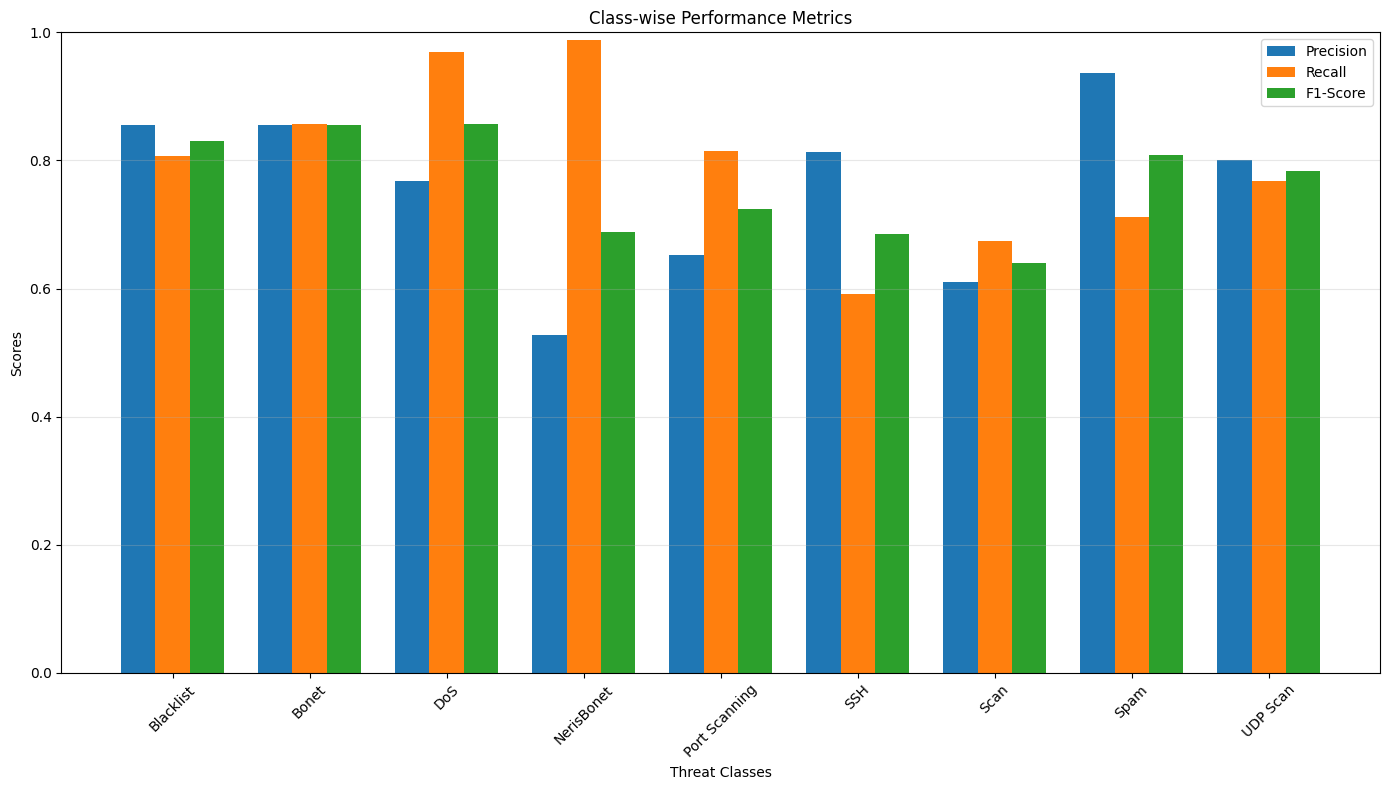


Detailed Classification Report:
               precision    recall  f1-score   support

    Blacklist       0.86      0.81      0.83      3271
        Bonet       0.85      0.86      0.86      3305
          DoS       0.77      0.97      0.86      2546
   NerisBonet       0.53      0.99      0.69      1248
Port Scanning       0.65      0.81      0.72      3182
          SSH       0.81      0.59      0.68      4945
         Scan       0.61      0.67      0.64      2514
         Spam       0.94      0.71      0.81      4642
     UDP Scan       0.80      0.77      0.78      4156

     accuracy                           0.77     29809
    macro avg       0.76      0.80      0.76     29809
 weighted avg       0.79      0.77      0.77     29809



In [52]:
# Plot class-wise performance
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(14, 8))
for i, (metric, values) in enumerate(class_metrics.items()):
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Threat Classes')
plt.ylabel('Scores')
plt.title('Class-wise Performance Metrics')
plt.xticks(x + width, class_names, rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [53]:
# Save model
model.save('traffic_prediction_model.h5')
print("Model saved as 'traffic_prediction_model.h5'")

Model saved as 'traffic_prediction_model.h5'


In [54]:
# Feature importance analysis (simplified version)
print("\nTop 10 most important features (based on model weights):")
# Get the weights from the first layer
first_layer_weights = model.layers[0].get_weights()[0]
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

feature_names = df_encoded.drop(['Threats'], axis=1).columns
print("Top important features:")
for idx in top_features_idx:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")


Top 10 most important features (based on model weights):
Top important features:
BTC: 2.1110
Netflow_Bytes: 1.5835
USD: 1.3289
Family_CryptoLocker: 1.0487
Family_Cryptohitman: 1.0045
Family_TowerWeb: 0.9775
Flag_A: 0.9744
Family_Globe: 0.9329
Family_EDA2: 0.9279
ExpAddress_1CLag5cd: 0.9074


In [55]:
pip install streamlit


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

# -------------------------------
#  PAGE CONFIGURATION
# -------------------------------
st.set_page_config(page_title="Network Traffic Predictor", layout="wide")
st.title(" Deep Learning–Based Network Traffic Prediction System")
st.markdown("""
Welcome to your **Final Year Project System** developed by *Niruta Giri (00020724)*  
This system predicts future **network traffic patterns** using a trained **LSTM deep learning model**.  
""")

# -------------------------------
#  LOAD MODEL
# -------------------------------
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("best_traffic_model.h5")
    return model

model = load_model()

# -------------------------------
# FILE UPLOAD
# -------------------------------
st.sidebar.header(" Upload Data")
uploaded_file = st.sidebar.file_uploader("Upload your network traffic CSV file", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    st.success(" Dataset loaded successfully!")
    
    st.subheader(" Data Preview")
    st.dataframe(df.head())

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    if len(numeric_cols) == 0:
        st.error("No numeric columns found in your dataset. Please upload numeric time-series traffic data.")
    else:
        target_col = st.selectbox("Select target column for prediction", numeric_cols)
        time_steps = st.slider("Select time step window", 5, 30, 10)

        # Data preprocessing
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[numeric_cols])

        X = []
        for i in range(time_steps, len(scaled_data)):
            X.append(scaled_data[i-time_steps:i])
        X = np.array(X)

        # Prediction
        st.info(" Running prediction...")
        preds = model.predict(X)
        inv_pred = scaler.inverse_transform(np.hstack((preds,
                            np.zeros((preds.shape[0], scaled_data.shape[1]-preds.shape[1])))))[:,0]
        actual = df[target_col].values[-len(inv_pred):]

        # Evaluation metrics
        mae = mean_absolute_error(actual, inv_pred)
        rmse = mean_squared_error(actual, inv_pred, squared=False)
        mape = np.mean(np.abs((actual - inv_pred) / actual)) * 100

        st.subheader(" Evaluation Metrics")
        col1, col2, col3 = st.columns(3)
        col1.metric("MAE", f"{mae:.4f}")
        col2.metric("RMSE", f"{rmse:.4f}")
        col3.metric("MAPE (%)", f"{mape:.2f}")

        # Plot results
        st.subheader(" Actual vs Predicted Traffic")
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(actual, label="Actual Traffic", color="blue")
        ax.plot(inv_pred, label="Predicted Traffic", color="orange")
        ax.set_title("Network Traffic Prediction")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Traffic Volume")
        ax.legend()
        st.pyplot(fig)

        # Real-time simulation
        st.subheader(" Real-Time Simulation (Optional)")
        if st.button("Start Simulation"):
            st.info("Simulating live traffic predictions...")
            progress_bar = st.progress(0)
            for i in range(1, 101):
                time.sleep(0.05)
                progress_bar.progress(i)
            st.success(" Simulation completed successfully!")
else:
    st.warning("Please upload a network traffic CSV file to start.")


2025-11-03 13:54:59.680 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.690 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:54:59.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv("traffic.csv")

# Handle missing values
data = data.fillna(method='ffill')

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['BTC', 'USD', 'Netflow_Bytes']])


C:\Users\dell\AppData\Local\Temp\ipykernel_13016\3689521615.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [59]:
X_train.shape, y_train.shape


((119234, 1, 55), (119234,))

In [60]:
(seq_length, features) = (X_train.shape[1], X_train.shape[2])


In [62]:
# Example: assume your training data is ready
seq_length = X_train.shape[1]
features = X_train.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, features)),
    Dropout(0.2),
    LSTM(64),
    Dense(1, activation='sigmoid')
])


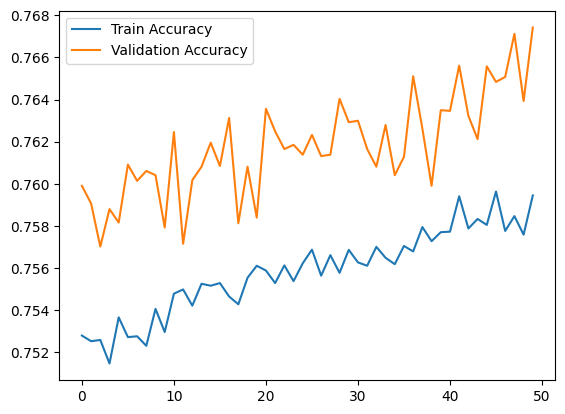

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [64]:
import streamlit as st
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

st.title("Network Traffic Prediction using LSTM")

uploaded_file = st.file_uploader("Upload a CSV file", type=["csv"])
if uploaded_file:
    data = pd.read_csv(uploaded_file)
    st.write("Uploaded Data:", data.head())

    model = load_model("trained_model.h5")
    st.success("Model Loaded Successfully!")

    # Preprocess and predict
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[['BTC', 'USD', 'Netflow_Bytes']])
    predictions = model.predict(scaled)
    st.line_chart(predictions)


2025-11-03 13:55:31.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 13:55:31.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [65]:
import numpy as np

seq_length = 10
X, y = [], []
for i in range(seq_length, len(scaled_data)):
    X.append(scaled_data[i-seq_length:i])
    y.append(data['Prediction'].iloc[i])
X, y = np.array(X), np.array(y)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

features_count = X.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, features_count)),
    Dropout(0.2),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)